<a href="https://colab.research.google.com/github/Loumstar/Improving-RoBERTa/blob/master/main_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTALLATIONS


All 

In [1]:
!nvidia-smi

Wed Mar  2 15:51:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers
!pip install sentencepiece
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install tensorboardx
!pip install wandb

     |████████████████████████████████| 3.5 MB 4.1 MB/s 
     |████████████████████████████████| 67 kB 6.5 MB/s 
     |████████████████████████████████| 895 kB 53.9 MB/s 
     |████████████████████████████████| 596 kB 66.1 MB/s 
     |████████████████████████████████| 6.5 MB 63.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 4.3 MB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
     |████████████████████████████████| 125 kB 4.1 MB/s 
     |████████████████████████████████| 1.7 MB 4.2 MB/s 
     |████████████████████████████████| 181 kB 84.5 MB/s 
     |████████████████████████████████| 144 kB 73.0 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=3a494f96aefdf46f7fcfc91ddca97d9b18909f2d0badfb3a

In [95]:
import torch
import transformers
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer
from transformers import BertPreTrainedModel, BertModel

from transformers import DebertaTokenizer, DebertaPreTrainedModel, DebertaForSequenceClassification

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, f1_score

if not torch.cuda.is_available():
  print('WARNING: You may want to change the runtime to GPU for faster training!')
  DEVICE = 'cpu'
else:
  DEVICE = 'cuda:0'

In [4]:
from urllib import request
import logging
from collections import Counter
from ast import literal_eval

In [5]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/'
%mkdir './nlp-cswrk'
%cd './nlp-cswrk' 

Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘./nlp-cswrk’: File exists
/content/drive/MyDrive/nlp-cswrk


In [6]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [7]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  b = f.read()
  outf.write(b.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv


In [8]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  b = f.read()
  outf.write(b.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv


In [9]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [10]:
from dont_patronize_me import DontPatronizeMe

In [11]:
dpm = DontPatronizeMe('.', '.')
dpm.load_task1()

In [12]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

# MODEL

## DATA IMPORT

In [13]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

In [14]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [15]:
print(dpm.train_task1_df.columns)

Index(['par_id', 'art_id', 'keyword', 'country', 'text', 'label',
       'orig_label'],
      dtype='object')


In [116]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
  country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
  intensity = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].orig_label.values[0]
  length = len(dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0])
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label,
      'keyword':keyword,
      'country':country,
      'intensity':intensity,
      'length':length
  })
trdf1 = pd.DataFrame(rows)

In [123]:
trdf1 = shuffle(trdf1)

In [120]:
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

trdf1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*3]])

In [124]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
  country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
  intensity = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].orig_label.values[0]
  length = len(dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0])
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label,
      'keyword':keyword,
      'country':country,
      'intensity':intensity,
      'length':length
  })
  tedf1 = pd.DataFrame(rows)

In [20]:
tedf1 = shuffle(tedf1)

In [21]:
def df_to_dict_of_lists(df):
    texts = df['text'].values.tolist()
    labels = df['label'].values.tolist()
    parids = df['par_id'].values.tolist()
    keywords = df['keyword'].values.tolist()
    countries = df['country'].values.tolist()
    intensities = df['intensity'].values.tolist()
    lengths = df['length'].values.tolist()
    return {'texts':texts,
            'labels':labels,
            'parids':parids,
            'keywords':keywords,
            'countries':countries,
            'intensities':intensities,
            'lengths':lengths}

In [22]:
class PatroDataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, input_set):

        self.tokenizer = tokenizer
        self.texts = input_set['texts']
        self.labels = input_set['labels']
        self.parids = input_set['parids']
        self.keywords = input_set['keywords']
        self.countries = input_set['countries']
        self.intensities = input_set['intensities']
        self.lengths = input_set['lengths']

        
    def collate_fn(self, batch):

        texts = []
        labels = []
        # parids = []
        # keywords = []
        # countries = []
        # intensities = []
        # lengths = []

        for b in batch:
            texts.append(b['text'])
            labels.append(b['label'])
            # parids.append(b['parids'])
            # keywords.append(b['keywords'])
            # countries.append(b['countries'])
            # intensities.append(b['intensities'])
            # lengths.append(b['lengths'])


        #The maximum sequence size for BERT is 512 but here the tokenizer truncate sentences longer than 128 tokens.  
        # We also pad shorter sentences to a length of 128 tokens
        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
        # labels = {}
        encodings['label'] =  torch.tensor(labels)
        
        return encodings
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
       
        item = {'text': self.texts[idx],
                'label': self.labels[idx],
                'parid': self.parids[idx],
                'keyword': self.keywords[idx],
                'countriy': self.countries[idx],
                'intensity': self.intensities[idx],
                'length': self.lengths[idx]
                }
        return item

In [23]:
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474 [00:00<?, ?B/s]

In [24]:
trainset = df_to_dict_of_lists(trdf1)
testset = df_to_dict_of_lists(tedf1)

train_dataset = PatroDataset(tokenizer, trainset)
test_dataset = PatroDataset(tokenizer, testset)

## MODEL

In [25]:
model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")

#180 M
print(f"Model size: {model.num_parameters()}")

Downloading:   0%|          | 0.00/533M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifi

Model size: 139193858


In [26]:
class Trainer_patronise(Trainer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.losses = []

    def compute_loss(self, model, inputs):
        labels = inputs.pop('label')

        outputs = model(**inputs)
        logits = outputs.get('logits')

        loss_task = nn.CrossEntropyLoss()

        loss = loss_task(logits, labels)
        self.losses.append(loss.item())
        
        return loss

In [27]:
def main_patronise():

    #call our custom BERT model and pass as parameter the name of an available pretrained model
    model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")
    
    training_args = TrainingArguments(
        output_dir='./',
        learning_rate = 0.0001,
        lr_scheduler_type = 'linear',
        logging_steps= 100,
        per_device_train_batch_size=32,
        num_train_epochs = 4,
        adam_beta1 = 0.9,
        adam_beta2 = 0.999,
        adam_epsilon = 1e-6,
        max_grad_norm = 1.0,
        save_steps = 2500
    )
    trainer = Trainer_patronise(
        model=model,                         
        args=training_args,                 
        train_dataset=train_dataset,                   
        data_collator=train_dataset.collate_fn
    )
    trainer.train()

    trainer.save_model('./')

    return trainer.losses


In [28]:
losses = main_patronise()

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifi

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
100,0.591900




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./
Configuration saved in ./config.json
Model weights saved in ./pytorch_model.bin


## EVALUATION

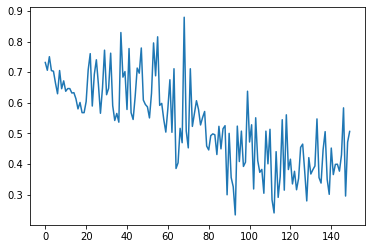

In [29]:
plt.plot(losses)

In [30]:
def predict_patronise(input, tokenizer, model): 
  model.eval()
  encodings = tokenizer(input, return_tensors='pt', padding=True, truncation=True, max_length=128)
  
  output = model(**encodings)
  preds = torch.max(output.logits, 1)

  return {'prediction':preds[1], 'confidence':preds[0]}

In [31]:
def evaluate(model, tokenizer, data_loader, test_df):

  total_count = 0
  correct_count = 0 

  preds = []
  tot_labels = []

  test_df['prediction'] = np.nan

  with torch.no_grad():
    for data in tqdm(data_loader):
      labels = {}
      labels['label'] = data['label']

      sentences = data['text']

      pred = predict_patronise(sentences, tokenizer, model)

      preds.append(pred['prediction'].tolist())
      tot_labels.append(labels['label'].tolist())

      for id, data_prediction in zip(data['parid'], pred['prediction']):
        rows = test_df.loc[test_df.par_id == id]
        rows.prediction = data_prediction.tolist()
        test_df.update(rows)

  # with the saved predictions and labels we can compute accuracy, precision, recall and f1-score
  report = classification_report(tot_labels, preds, target_names=[0,1], output_dict= True)

  return report, test_df

In [ ]:
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

#your saved model name here
model_name = './'
model = DebertaForSequenceClassification.from_pretrained(model_name)

# we don't batch our test set unless it's too big
test_loader = DataLoader(test_dataset)

report, annotated_test_dataset = evaluate(model, tokenizer, test_loader, tedf1)

print(report)

print(report['accuracy'])
print(report[0]['f1-score'])
print(report[1]['f1-score'])

In [56]:
annotated_test_dataset

,par_id,text,label,keyword,country,intensity,length,prediction
1897,10247,Australian Prime Minister Malcolm Turnbull neg...,0.0,refugee,sg,0,218.0,0.0
53,1477,Haiti has legal protections for the disabled o...,1.0,disabled,ph,3,358.0,1.0
1016,9278,OTTAWA - Canadians who sponsor grandma and gra...,0.0,immigrant,ca,0,153.0,0.0
1342,9632,There is no real reason to suppose that some o...,0.0,migrant,bd,0,382.0,0.0
699,8932,"""Despite the passage of 70 years since their f...",0.0,refugee,in,0,724.0,0.0
...,...,...,...,...,...,...,...,...
826,9074,"""Her first novel """" Tim """" was published in 19...",0.0,disabled,hk,0,190.0,0.0
231,8422,"MANILA , Philippines - The government will hol...",0.0,poor-families,ph,1,133.0,1.0
1763,10106,""""""" For so long we are solely dependent on rai...",0.0,in-need,jm,0,392.0,0.0
74,8979,The vast majority of girls and women caught in...,1.0,poor-families,ca,3,444.0,1.0


In [98]:
def analysis_on_intensities(annotated_dataset):
    scores = []
    for intensity_value in range(0,5):
        subset_dataset = annotated_dataset.loc[annotated_dataset.intensity.map(int) == intensity_value]
        labels = subset_dataset['label'].tolist()
        preds = subset_dataset['prediction'].tolist()
        score = f1_score(labels, preds)
        print(score)
        scores.append(score)
    return scores

In [99]:
analysis_on_intensities(annotated_test_dataset)

0.0
0.0
0.0
1.0
0.8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[0.0, 0.0, 0.0, 1.0, 0.8]

In [ ]:
def f1_score_on

In [34]:
print(report['accuracy'])
print(report[0]['f1-score'])
print(report[1]['f1-score'])

0.88
0.9310344827586207
0.5384615384615385


In [35]:

report = classification_report(tot_labels, preds, target_names=[0,1], output_dict= True)


NameError: ignored